# 📊 Evaluation Pipeline: DWF RL Model
This notebook evaluates the trained RL model’s performance using core metrics like cancellation rate, rider wait time, and profit impact.

In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
from matplotlib import pyplot as plt

In [ ]:
# Load the retrained PPO model with 8-dimensional observation space
model = PPO.load("dwf_rl_pricing_model_v6")


In [ ]:
# Load the evaluation dataset
df = pd.read_csv("synthetic_ride_hailing_dataset.csv")

In [ ]:
# Derive success (pickup completed) based on Cancellation Rate (CR)
df['pickup_success'] = (df['CR'] < 0.5).astype(int)

In [ ]:
# Compute Evaluation Metrics
completion_rate = df['pickup_success'].mean()
average_incentive = df['incentive'].mean()
average_discount = df['fare_adjustment'].clip(upper=0).abs().mean()
simulated_platform_cost = average_incentive + average_discount

In [ ]:
# Print the Results
print(f"✅ Completion Rate: {completion_rate:.2f}")
print(f"✅ Avg Incentive: ${average_incentive:.2f}")
print(f"✅ Avg Discount: ${average_discount:.2f}")
print(f"✅ Simulated Platform Cost: ${simulated_platform_cost:.2f}")

✅ Completion Rate: 0.43
✅ Avg Incentive: $2.49
✅ Avg Discount: $0.04
✅ Simulated Platform Cost: $2.53


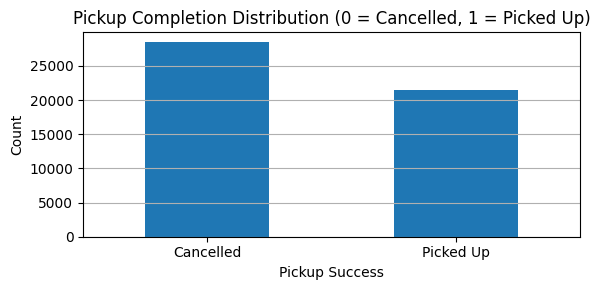

In [ ]:
# Plot Completion Histogram
plt.figure(figsize=(6, 3))
df['pickup_success'].value_counts().sort_index().plot(kind='bar')
plt.title("Pickup Completion Distribution (0 = Cancelled, 1 = Picked Up)")
plt.xlabel("Pickup Success")
plt.ylabel("Count")
plt.xticks([0, 1], ['Cancelled', 'Picked Up'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Model Evaluation

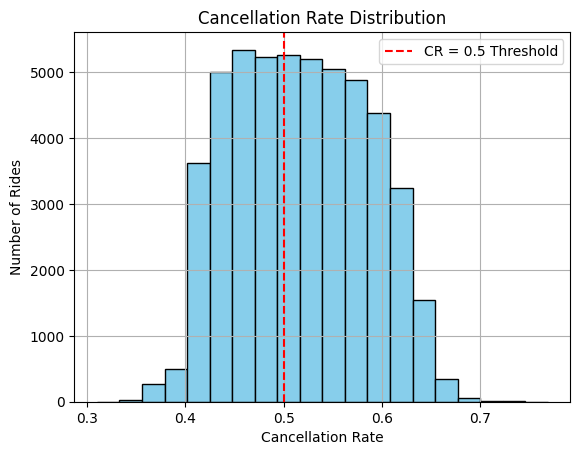

In [10]:
plt.hist(df['CR'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='CR = 0.5 Threshold')
plt.title("Cancellation Rate Distribution")
plt.xlabel("Cancellation Rate")
plt.ylabel("Number of Rides")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x='pickup_success', y='total_cost', data=df)
plt.xticks([0, 1], ['Cancelled', 'Completed'])
plt.title("Total Cost Distribution by Ride Outcome")
plt.ylabel("Total Cost ($)")
plt.xlabel("Ride Outcome")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

<Figure size 600x400 with 0 Axes>